## 1. 라이브러리 불러오기


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


- torch: PyTorch 라이브러리

- torch.nn: 신경망을 구축하는 모듈

- torch.optim: 최적화(Gradient Descent) 관련 모듈

- torchvision: 이미지 처리 관련 모듈

- numpy: 수치 연산 라이브러리

- matplotlib.pyplot: 그래프 시각화 도구

## 2. GPU 사용 여부 설정

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- 사용 가능한 GPU가 있으면 cuda 사용, 없으면 CPU 사용

## 3.데이터 로드 및 변환

In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]


transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환

MNIST(): MNIST 데이터셋 다운로드

DataLoader(): 배치 단위로 데이터를 나누고, 학습을 원활하게 진행

batch_size=256: 한 번에 256개 샘플 사용

shuffle=True: 데이터 순서 섞기 (훈련 데이터는 섞지만, 테스트 데이터는 그대로)

## 4. 신경망 모델 정의

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # 입력층 (28x28=784) → 은닉층 (128 뉴런)
        self.fc2 = nn.Linear(128, 64)     # 은닉층 (128) → 은닉층 (64)
        self.fc3 = nn.Linear(64, 10)      # 은닉층 (64) → 출력층 (10, 클래스 수)
        self.relu = nn.ReLU()             # 활성화 함수: ReLU

    def forward(self, x):
        x = x.view(-1, 28*28)             # 2D 이미지를 1D 벡터로 변환
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)                   # 최종 출력층: Softmax 적용 필요 없음 (CrossEntropyLoss 사용 예정)
        return x


ReLU (Rectified Linear Unit) 활성화 함수 사용

CrossEntropyLoss 사용 예정이므로 출력층에서 Softmax를 적용하지 않음 (PyTorch CrossEntropyLoss가 내부적으로 처리)



## 5. 모델 및 손실 함수, 옵티마이저 설정

In [6]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.to(device): 모델을 GPU 또는 CPU에 할당

nn.CrossEntropyLoss(): 다중 클래스 분류에 적합한 손실 함수 (Softmax 포함)

optim.Adam(): Adam 옵티마이저 사용 (학습률 lr=0.001)

## 6. 정확도 측정 함수


In [7]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    model.eval()  # 평가 모드 전환
    with torch.no_grad():  # 그래디언트 계산 방지 (메모리 절약)
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)  # 가장 높은 확률의 클래스 선택
            cnt += labels.shape[0]  # 전체 샘플 개수
            acc += (labels == preds).sum().item()  # 맞춘 개수 합산
    model.train()  # 다시 학습 모드로 변경
    return acc / cnt  # 정확도 반환


argmax(dim=-1): 가장 확률이 높은 클래스를 선택

with torch.no_grad(): 평가 시에는 그래디언트 계산을 하지 않음 (속도 향상)

## 7. 모델 학습

In [8]:
n_epochs = 100
train_accs, test_accs = [], []

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # 이전 그래디언트 초기화
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()

    train_acc = accuracy(model, trainloader)  # 훈련 데이터 정확도
    test_acc = accuracy(model, testloader)  # 테스트 데이터 정확도
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/100, Loss: 0.5347, Train Acc: 0.9299, Test Acc: 0.9310
Epoch 2/100, Loss: 0.2059, Train Acc: 0.9522, Test Acc: 0.9534
Epoch 3/100, Loss: 0.1525, Train Acc: 0.9618, Test Acc: 0.9603
Epoch 4/100, Loss: 0.1224, Train Acc: 0.9693, Test Acc: 0.9652
Epoch 5/100, Loss: 0.1016, Train Acc: 0.9761, Test Acc: 0.9682
Epoch 6/100, Loss: 0.0846, Train Acc: 0.9785, Test Acc: 0.9692
Epoch 7/100, Loss: 0.0728, Train Acc: 0.9805, Test Acc: 0.9712
Epoch 8/100, Loss: 0.0626, Train Acc: 0.9853, Test Acc: 0.9720
Epoch 9/100, Loss: 0.0522, Train Acc: 0.9881, Test Acc: 0.9746
Epoch 10/100, Loss: 0.0445, Train Acc: 0.9862, Test Acc: 0.9728
Epoch 11/100, Loss: 0.0397, Train Acc: 0.9917, Test Acc: 0.9732
Epoch 12/100, Loss: 0.0335, Train Acc: 0.9922, Test Acc: 0.9763
Epoch 13/100, Loss: 0.0303, Train Acc: 0.9937, Test Acc: 0.9758
Epoch 14/100, Loss: 0.0250, Train Acc: 0.9947, Test Acc: 0.9769
Epoch 15/100, Loss: 0.0214, Train Acc: 0.9964, Test Acc: 0.9777
Epoch 16/100, Loss: 0.0179, Train Acc: 0.9942, Te

optimizer.zero_grad(): 기울기 초기화

loss.backward(): 역전파 수행

optimizer.step(): 가중치 업데이트

running_loss: 각 미니배치 손실값을 누적

매 epoch마다 정확도를 측정하여 출력

## 8. 정확도 그래프 출력

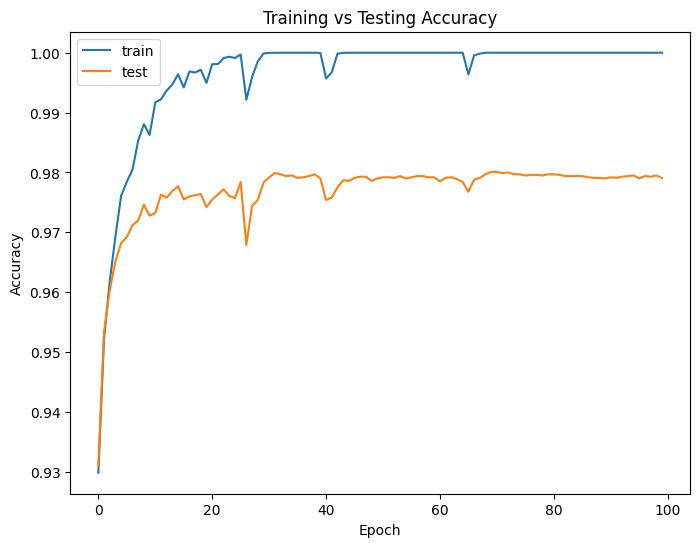

In [9]:
plt.figure(figsize=(8, 6))
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy")
    plt.show()

plot_acc(train_accs, test_accs)


train_accs와 test_accs를 그래프로 시각화

plt.plot()을 이용해 학습 과정에서 정확도가 어떻게 변화하는지 확인 가능



데이터 전처리

transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환

DataLoader: 미니배치 단위로 데이터 로딩

신경망 구조

다층 퍼셉트론(MLP, Multi-Layer Perceptron) 구조

ReLU 활성화 함수 사용

CrossEntropyLoss를 고려하여 마지막 Softmax 적용하지 않음

학습 및 최적화

Adam 옵티마이저 사용 (lr=0.001)

CrossEntropyLoss 적용

accuracy() 함수를 사용하여 모델 성능 평가

성능 평가 및 시각화

accuracy() 함수로 정확도 측정

matplotlib을 활용한 정확도 변화 그래프 시각화

